In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import scanpy as sc
import rapids_singlecell as rsc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import anndata as ad
print(f"rapids-singlecell: {rsc.__version__}\n"
      f"scanpy: {sc.__version__}\n"
      f"pandas: {pd.__version__}\n"
      f"numpy: {np.__version__}\n"
      f"seaborn: {sns.__version__}\n"
      f"anndata: {ad.__version__}")

2025-12-15 10:50:37.379277: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765813837.394890   65518 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765813837.399600   65518 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1765813837.412708   65518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765813837.412728   65518 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1765813837.412731   65518 computation_placer.cc:177] computation placer alr

rapids-singlecell: 0.11.1
scanpy: 1.10.4
pandas: 2.2.2
numpy: 1.26.0
seaborn: 0.13.2
anndata: 0.11.3


#### Data available from here:
Download datasets from here and unpack into datasets/ directory. These files contain precomputed scGPT embeddings in 'adata.obsm['scGPT']'


In [3]:
xenAD = sc.read_h5ad('../datasets/xenium_scGPT.h5ad')

scAD = sc.read_h5ad('../datasets/scRNAseq_scGPT.h5ad')


In [4]:
xenAD

AnnData object with n_obs × n_vars = 38280 × 342
    obs: 'sample', 'patient', 'cell_id', 'full_cell_id', 'sample_type', 'sample_affect', 'disease_status', 'percent_pathology', 'tma', 'run', 'final_CT', 'final_lineage', 'CNiche', 'TNiche', 'lumen_id', 'lumen_rank', 'x_centroid', 'y_centroid', 'adj_x_centroid', 'adj_y_centroid', 'super_adj_x_centroid', 'super_adj_y_centroid', 'nCount_RNA', 'nFeature_RNA', 'perc_negcontrolprobe', 'perc_negcontrolcodeword', 'perc_unassigned', 'perc_negcontrolorunassigned', 'nCount_niche', 'nFeature_niche', 'assay', 'sID', 'predicted_celltype'
    var: 'mean', 'std', 'gene_id', 'n_counts', 'index', 'id_in_vocab'
    uns: 'log1p'
    obsm: 'X_SP', 'X_celltype_probs', 'X_pca', 'X_scGPT', 'X_sp', 'X_umap', 'bin_edges'
    varm: 'PCs'
    layers: 'X_binned', 'X_log1p', 'X_normed'

In [5]:
scAD

AnnData object with n_obs × n_vars = 26323 × 25425
    obs: 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'Sample_Name', 'Diagnosis', 'Sample_Source', 'Sample_Type', 'Tobacco', 'Status', 'Flowcell_ID', 'Processing_site', 'Gender', 'Age', 'Ethnicity', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'Short_Sample_Name', 'manual_annotation_1', 'annotation_level_1', 'annotation_level_2', 'lineage', 'assay', 'annotation_level_0', 'sID'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'gene_id', 'n_counts', 'index', 'id_in_vocab'
    uns: 'annotation_level_0_colors', 'log1p', 'neighbors', 'umap'
    obsm: 'X_celltype_probs', 'X_scGPT', 'X_umap', 'bin_edges'
    layers: 'X_binned', 'X_log1p', 'X_normed'
    obsp: 'connectivities', 'distances'

Text(0.5, 1.0, '\n Xenium')

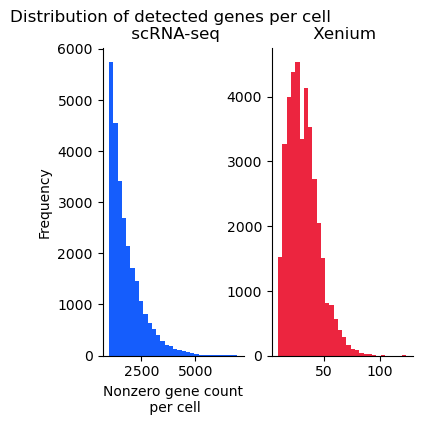

In [6]:

fig, ax = plt.subplots(1, 2, figsize=(4, 4))

counts, bins, _ = ax[1].hist((xenAD.X != 0).sum(axis=1), bins=30, color="#EC253F")

counts, bins, _ = ax[0].hist((scAD.X != 0).sum(axis=1), bins=30, color="#155DFC")
ax[0].set_xlabel("Nonzero gene count\n per cell")
ax[0].set_ylabel("Frequency")
ax[1].set_xlabel("")
ax[1].set_ylabel("")
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[0].set_title("Distribution of detected genes per cell \n scRNA-seq")
ax[1].set_title("\n Xenium")



In [7]:
xenAD_scGPT = ad.AnnData(X= xenAD.obsm['X_scGPT'], obs= xenAD.obs, obsm=xenAD.obsm)
xenAD_scGPT.obs['assay'] = 'Xenium'
xenAD_scGPT.obs['cell_type'] = xenAD.obs['predicted_celltype']
scAD_scGPT = ad.AnnData(X= scAD.obsm['X_scGPT'], obs= scAD.obs, obsm=scAD.obsm)
scAD_scGPT.obs['assay'] = 'scRNA-seq'
scAD_scGPT.obs['cell_type'] = scAD.obs['annotation_level_0']

combinedAD = ad.concat([xenAD_scGPT, scAD_scGPT], axis=0, label='batch')

In [8]:
rsc.pp.neighbors(xenAD_scGPT, use_rep='X', metric='cosine')
rsc.pp.neighbors(scAD_scGPT, use_rep='X', metric='cosine')
rsc.pp.neighbors(combinedAD, use_rep='X', metric='cosine')
rsc.tl.umap(xenAD_scGPT)
rsc.tl.umap(scAD_scGPT)
rsc.tl.umap(combinedAD)

In [9]:
ctype_palette = sc.pl.palettes.default_20
ctype_colors = {ct: c for ct, c in zip(sorted(combinedAD.obs['cell_type'].unique()), ctype_palette)}
assay_colors = {'Xenium': '#EC253F', 'scRNA-seq':'#155DFC'}

Text(0.5, 1.0, 'Cell type')

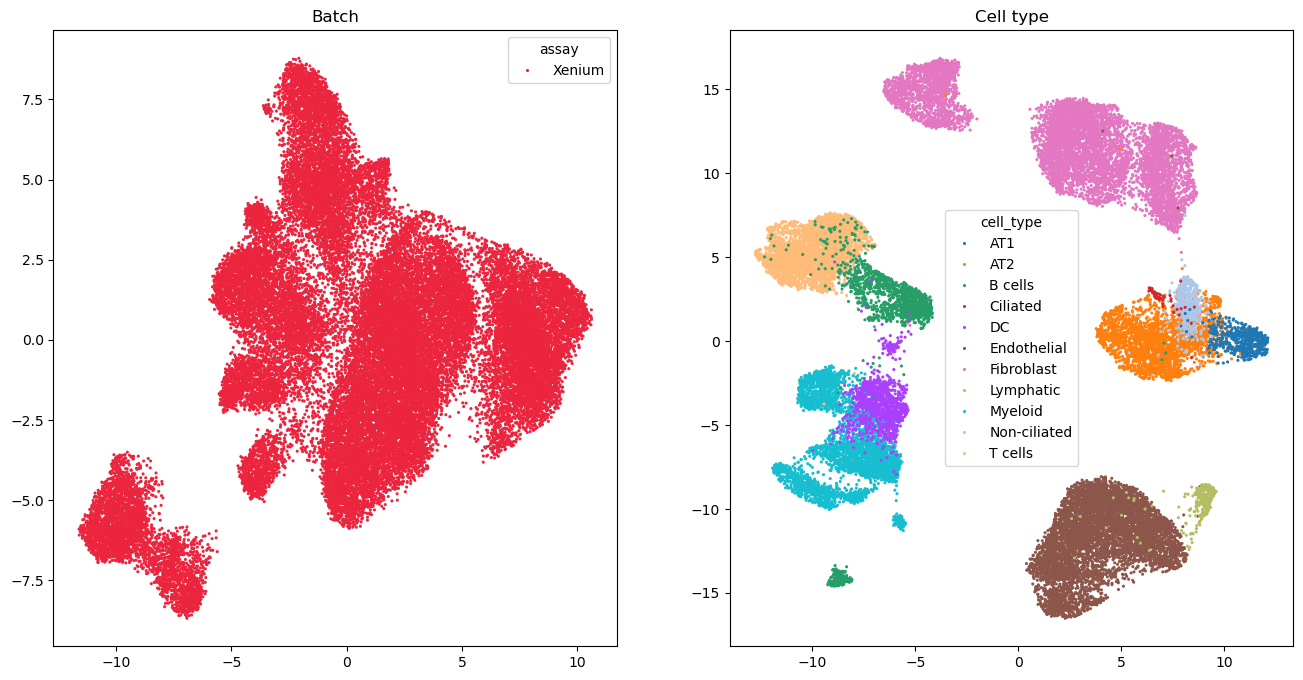

In [10]:


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(x=xenAD_scGPT.obsm['X_umap'][:, 0], y=xenAD_scGPT.obsm['X_umap'][:, 1], hue=xenAD_scGPT.obs['assay'], palette=assay_colors, s=5, linewidth=0, ax=ax[0])
sns.scatterplot(x=scAD_scGPT.obsm['X_umap'][:, 0], y=scAD_scGPT.obsm['X_umap'][:, 1], hue=scAD_scGPT.obs['cell_type'], palette=ctype_colors, s=5, linewidth=0, ax=ax[1])

ax[0].set_title('Batch')
ax[1].set_title('Cell type')





Text(0.5, 1.0, 'Cell type')

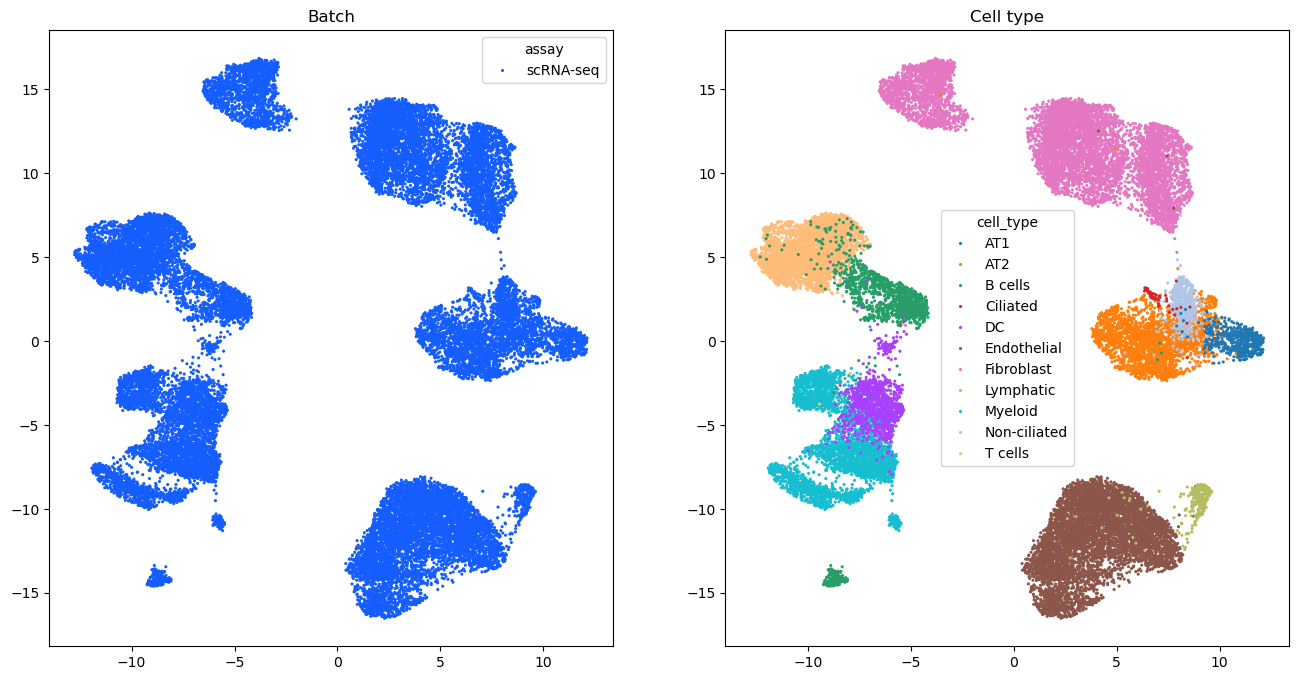

In [11]:


fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(x=scAD_scGPT.obsm['X_umap'][:, 0], y=scAD_scGPT.obsm['X_umap'][:, 1], hue=scAD_scGPT.obs['assay'], palette=assay_colors, s=5, linewidth=0, ax=ax[0])
sns.scatterplot(x=scAD_scGPT.obsm['X_umap'][:, 0], y=scAD_scGPT.obsm['X_umap'][:, 1], hue=scAD_scGPT.obs['cell_type'], palette=ctype_colors, s=5, linewidth=0, ax=ax[1])

ax[0].set_title('Batch')
ax[1].set_title('Cell type')



Text(0.5, 1.0, 'Cell type')

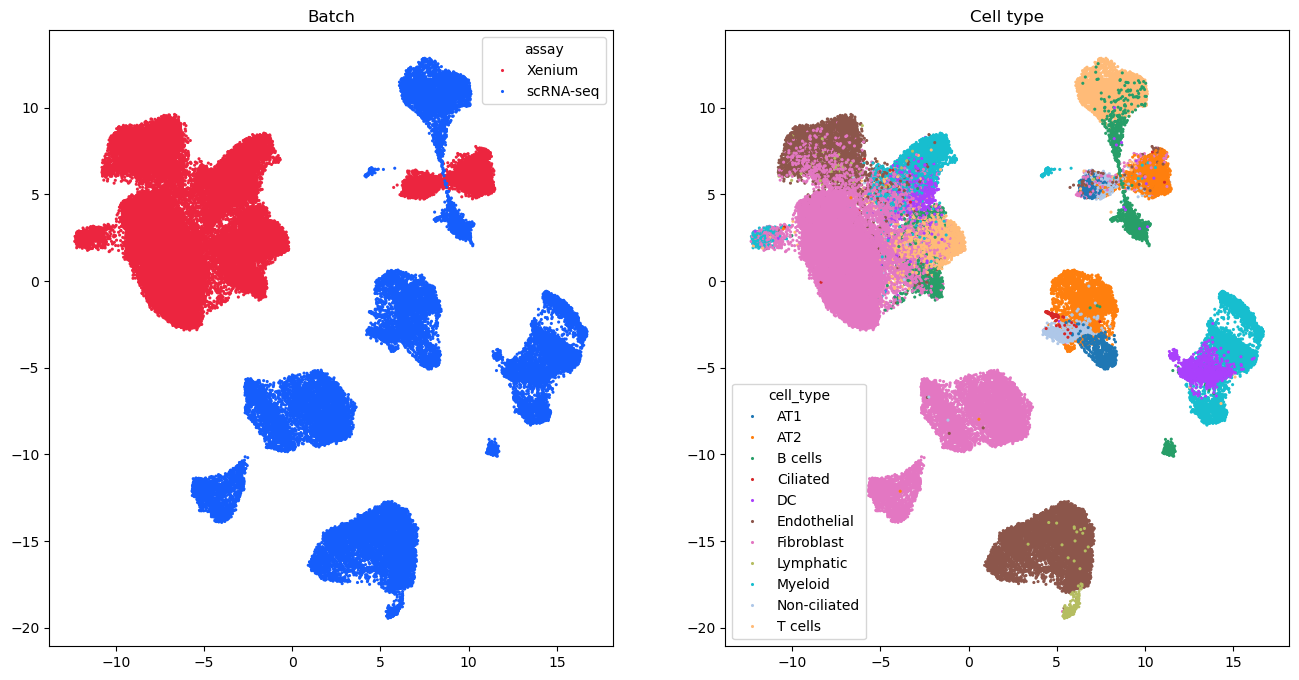

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.scatterplot(x=combinedAD.obsm['X_umap'][:, 0], y=combinedAD.obsm['X_umap'][:, 1], hue=combinedAD.obs['assay'], palette=assay_colors, s=5, linewidth=0, ax=ax[0])
sns.scatterplot(x=combinedAD.obsm['X_umap'][:, 0], y=combinedAD.obsm['X_umap'][:, 1], hue=combinedAD.obs['cell_type'], palette=ctype_colors, s=5, linewidth=0, ax=ax[1])

ax[0].set_title('Batch')
ax[1].set_title('Cell type')


In [13]:
import sys
sys.path.append('../src/')

from run_usher import align_features_fgw


In [ ]:
model, mapping_final, concat_adata, T_full, scaler_mean, scaler_std = align_features_fgw(
    xenAD_scGPT.copy(),
    scAD_scGPT.copy(),
    e_step_method="fgw",
    alpha=0.3, 
    lambda_cross=0.9,
    lambda_var=0.1,
    cell_type_col="cell_type",
    celltype_probs_layer="X_celltype_probs",
    sketch_size=4300,
    knn_k=30,
    metric="cosine",
    m_step_metric="euclidean",
    gamma=0.,
    epsilon=0.05,
    use_linear_assignment=True,
    sinkhorn_iters=1000,
    n_iters=10,
    steps_per_iter=100,
    lr=1e-3,
    hidden_dim=512,
    debug_plots_path="../datasets/scGPT_example/",)



2025-12-15 11:03:24,090 - INFO - Using device: cuda
2025-12-15 11:03:24,097 - INFO - Logging to file: ../datasets/scGPT_example/alignment.log
2025-12-15 11:03:24,181 - INFO - Source (A): 38280 spots, 512 features. Target (B): 26323 spots, 512 features.
2025-12-15 11:03:24,182 - INFO - E-step method: fgw
2025-12-15 11:03:24,183 - INFO - M-step method: global
2025-12-15 11:03:24,183 - INFO - M-step method: global (lr=0.001, steps_per_iter=100)
2025-12-15 11:03:24,183 - INFO - Distance metric (kNN/UMAP/M-step loss): cosine
2025-12-15 11:03:24,184 - INFO - kNN graph: enabled (k=30)
2025-12-15 11:03:24,184 - INFO - Gamma (feature weight in M): 0.0 (iter 0 uses gamma=0)
2025-12-15 11:03:24,185 - INFO - === Using CELLTYPE sampling strategy ===
2025-12-15 11:03:24,190 - INFO - Loading cell type probabilities for fgw method...
2025-12-15 11:03:24,193 - INFO - Loaded cell type probabilities from .obsm['X_celltype_probs']: shape (38280, 11)
2025-12-15 11:03:24,194 - INFO - Loaded cell type probab

Max. shortest path distance: 7.0


2025-12-15 11:03:58,114 - INFO - M_features metric: cosine.
2025-12-15 11:03:58,127 - INFO -   FGW: gamma=1.00, M_aux.mean=0.7039, M_features.mean=0.4321
2025-12-15 11:03:58,128 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:03:58,133 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5000
2025-12-15 11:03:58,134 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:03:58,135 - INFO -   FGW: M stats - min=0.0000, max=1.0000, mean=0.7039


Max. shortest path distance: 11.0


/hpc/group/singhlab/rawdata/ap756/rapidsc/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


It.  |Err         
-------------------
    0|4.992112e-04|


2025-12-15 11:04:03,313 - INFO -   FGW: T stats - min=4.38100858e-12, max=1.65206287e-02, nnz=17516395/18490000
2025-12-15 11:04:03,339 - INFO -   Entropy filtering: 3693/4300 cells focused (85.9%) [entropy_th=7.9629, conf_th=0.0008]


   10|2.509700e-10|


2025-12-15 11:04:09,436 - INFO -   Cell type accuracy (ALL): 3346/4300 correct (77.8%)
2025-12-15 11:04:09,438 - INFO -   Cell type accuracy (FOCUSED/M-step): 3107/3693 correct (84.1%)
2025-12-15 11:04:09,438 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:04:09,440 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:04:19,855 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 6.0


2025-12-15 11:04:29,576 - INFO - M_features metric: cosine.
2025-12-15 11:04:29,580 - INFO -   FGW: gamma=1.00, M_aux.mean=0.7027, M_features.mean=0.4323
2025-12-15 11:04:29,581 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:04:29,582 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5799
2025-12-15 11:04:29,583 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:04:29,584 - INFO -   FGW: M stats - min=0.0000, max=1.0000, mean=0.7027


Max. shortest path distance: 10.0


/hpc/group/singhlab/rawdata/ap756/rapidsc/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


It.  |Err         
-------------------
    0|5.019156e-04|


2025-12-15 11:04:34,664 - INFO -   FGW: T stats - min=2.75063501e-12, max=2.61543654e-02, nnz=17332801/18490000
2025-12-15 11:04:34,670 - INFO -   Entropy filtering: 3684/4300 cells focused (85.7%) [entropy_th=7.9446, conf_th=0.0008]


   10|3.064553e-10|


2025-12-15 11:04:40,239 - INFO -   Cell type accuracy (ALL): 3379/4300 correct (78.6%)
2025-12-15 11:04:40,241 - INFO -   Cell type accuracy (FOCUSED/M-step): 3122/3684 correct (84.7%)
2025-12-15 11:04:40,241 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:04:40,243 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:04:50,653 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 6.0


2025-12-15 11:05:00,352 - INFO - M_features metric: cosine.
2025-12-15 11:05:00,355 - INFO -   FGW: gamma=1.00, M_aux.mean=0.7032, M_features.mean=0.4727
2025-12-15 11:05:00,356 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:05:00,357 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5800
2025-12-15 11:05:00,358 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:05:00,358 - INFO -   FGW: M stats - min=0.0000, max=1.0000, mean=0.7032


Max. shortest path distance: 10.0


/hpc/group/singhlab/rawdata/ap756/rapidsc/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


It.  |Err         
-------------------
    0|4.966813e-04|


2025-12-15 11:05:05,414 - INFO -   FGW: T stats - min=2.22687038e-12, max=7.23469183e-02, nnz=17304609/18490000
2025-12-15 11:05:05,416 - INFO -   Entropy filtering: 3699/4300 cells focused (86.0%) [entropy_th=7.9596, conf_th=0.0008]


   10|2.901390e-10|


2025-12-15 11:05:11,610 - INFO -   Cell type accuracy (ALL): 3346/4300 correct (77.8%)
2025-12-15 11:05:11,612 - INFO -   Cell type accuracy (FOCUSED/M-step): 3145/3699 correct (85.0%)
2025-12-15 11:05:11,612 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:05:11,614 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:05:21,935 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 7.0


2025-12-15 11:05:31,559 - INFO - M_features metric: cosine.
2025-12-15 11:05:31,564 - INFO -   FGW: gamma=1.00, M_aux.mean=0.7074, M_features.mean=0.4420
2025-12-15 11:05:31,565 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:05:31,566 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5042
2025-12-15 11:05:31,567 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:05:31,568 - INFO -   FGW: M stats - min=0.0000, max=1.0000, mean=0.7074


Max. shortest path distance: 12.0


/hpc/group/singhlab/rawdata/ap756/rapidsc/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


It.  |Err         
-------------------
    0|4.958597e-04|


2025-12-15 11:05:36,606 - INFO -   FGW: T stats - min=6.11735543e-13, max=2.44956762e-02, nnz=17018100/18490000
2025-12-15 11:05:36,610 - INFO -   Entropy filtering: 3684/4300 cells focused (85.7%) [entropy_th=7.9982, conf_th=0.0008]


   10|2.393993e-10|


2025-12-15 11:05:42,380 - INFO -   Cell type accuracy (ALL): 3314/4300 correct (77.1%)
2025-12-15 11:05:42,381 - INFO -   Cell type accuracy (FOCUSED/M-step): 3106/3684 correct (84.3%)
2025-12-15 11:05:42,382 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:05:42,384 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:05:52,753 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 7.0


2025-12-15 11:06:02,409 - INFO - M_features metric: cosine.
2025-12-15 11:06:02,412 - INFO -   FGW: gamma=1.00, M_aux.mean=0.7085, M_features.mean=0.4675
2025-12-15 11:06:02,413 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:06:02,415 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5091
2025-12-15 11:06:02,416 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:06:02,417 - INFO -   FGW: M stats - min=0.0000, max=1.0000, mean=0.7085


Max. shortest path distance: 12.0


/hpc/group/singhlab/rawdata/ap756/rapidsc/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


It.  |Err         
-------------------
    0|5.052403e-04|


2025-12-15 11:06:07,471 - INFO -   FGW: T stats - min=1.97791206e-13, max=3.54528539e-02, nnz=16858366/18490000
2025-12-15 11:06:07,474 - INFO -   Entropy filtering: 3670/4300 cells focused (85.3%) [entropy_th=8.0278, conf_th=0.0007]


   10|2.566191e-10|


2025-12-15 11:06:12,853 - INFO -   Cell type accuracy (ALL): 3258/4300 correct (75.8%)
2025-12-15 11:06:12,854 - INFO -   Cell type accuracy (FOCUSED/M-step): 3078/3670 correct (83.9%)
2025-12-15 11:06:12,856 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:06:12,857 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:06:23,238 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 7.0


2025-12-15 11:06:32,935 - INFO - M_features metric: cosine.
2025-12-15 11:06:32,940 - INFO -   FGW: gamma=1.00, M_aux.mean=0.7124, M_features.mean=0.4659
2025-12-15 11:06:32,941 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:06:32,941 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5089
2025-12-15 11:06:32,942 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:06:32,943 - INFO -   FGW: M stats - min=0.0000, max=1.0000, mean=0.7124


Max. shortest path distance: 15.0


/hpc/group/singhlab/rawdata/ap756/rapidsc/lib/python3.12/site-packages/ot/bregman/_sinkhorn.py:667: UserWarning: Sinkhorn did not converge. You might want to increase the number of iterations `numItermax` or the regularization parameter `reg`.
  warnings.warn(


It.  |Err         
-------------------
    0|5.025227e-04|


2025-12-15 11:06:37,981 - INFO -   FGW: T stats - min=1.38586909e-13, max=3.91857699e-02, nnz=16801858/18490000
2025-12-15 11:06:37,986 - INFO -   Entropy filtering: 3678/4300 cells focused (85.5%) [entropy_th=8.1138, conf_th=0.0007]


   10|2.181795e-10|


2025-12-15 11:06:43,794 - INFO -   Cell type accuracy (ALL): 3136/4300 correct (72.9%)
2025-12-15 11:06:43,795 - INFO -   Cell type accuracy (FOCUSED/M-step): 3048/3678 correct (82.9%)
2025-12-15 11:06:43,796 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:06:43,799 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:06:43,799 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3693/4300 cells)
2025-12-15 11:06:43,802 - INFO -   Batch 1: Selected 3693/4300 cells (85.9%)
2025-12-15 11:06:43,803 - INFO -   Batch 2: Using pre-computed focused_mask from E-step (3684/4300 cells)
2025-12-15 11:06:43,804 - INFO -   Batch 2: Selected 3684/4300 cells (85.7%)
2025-12-15 11:06:43,804 - INFO -   Batch 3: Using pre-computed focused_mask from E-step (3699/4300 cells)
2025-12-15 11:06:43,805 - INFO -   Batch 3: Selected 3699/4300 cells (86.0%)
2025-12-15 11:06:43,806 - INFO -   Batch 4: Using pre-computed focused_mask from E-step (3684/4300 cells)
2

Max. shortest path distance: 9.0


2025-12-15 11:07:10,867 - INFO - M_features metric: cosine.
2025-12-15 11:07:10,870 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2681
2025-12-15 11:07:10,871 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:07:10,872 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4843
2025-12-15 11:07:10,873 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:07:10,874 - INFO -   FGW: M stats - min=0.0169, max=1.0000, mean=0.2681


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|3.333068e-04|


2025-12-15 11:07:11,258 - INFO -   FGW: T stats - min=1.21038383e-07, max=2.18952391e-02, nnz=18490000/18490000
2025-12-15 11:07:11,260 - INFO -   Entropy filtering: 3624/4300 cells focused (84.3%) [entropy_th=8.1088, conf_th=0.0009]


   10|1.767904e-10|


2025-12-15 11:07:15,320 - INFO -   Cell type accuracy (ALL): 3000/4300 correct (69.8%)
2025-12-15 11:07:15,321 - INFO -   Cell type accuracy (FOCUSED/M-step): 2668/3624 correct (73.6%)
2025-12-15 11:07:15,322 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:07:15,327 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:07:25,875 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:07:35,591 - INFO - M_features metric: cosine.
2025-12-15 11:07:35,596 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2791
2025-12-15 11:07:35,596 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:07:35,597 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4828
2025-12-15 11:07:35,598 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:07:35,598 - INFO -   FGW: M stats - min=0.0206, max=1.0000, mean=0.2791


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|3.467209e-04|


2025-12-15 11:07:35,980 - INFO -   FGW: T stats - min=1.09342622e-07, max=1.99061055e-02, nnz=18490000/18490000
2025-12-15 11:07:35,982 - INFO -   Entropy filtering: 3609/4300 cells focused (83.9%) [entropy_th=8.0854, conf_th=0.0009]


   10|1.988070e-10|


2025-12-15 11:07:40,058 - INFO -   Cell type accuracy (ALL): 3065/4300 correct (71.3%)
2025-12-15 11:07:40,059 - INFO -   Cell type accuracy (FOCUSED/M-step): 2699/3609 correct (74.8%)
2025-12-15 11:07:40,060 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:07:40,065 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:07:50,664 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:08:00,705 - INFO - M_features metric: cosine.
2025-12-15 11:08:00,708 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2887
2025-12-15 11:08:00,709 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:08:00,710 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4861
2025-12-15 11:08:00,711 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:08:00,712 - INFO -   FGW: M stats - min=0.0213, max=1.0000, mean=0.2887


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|3.595296e-04|


2025-12-15 11:08:01,099 - INFO -   FGW: T stats - min=8.14917698e-08, max=2.33156420e-02, nnz=18490000/18490000
2025-12-15 11:08:01,101 - INFO -   Entropy filtering: 3613/4300 cells focused (84.0%) [entropy_th=8.0600, conf_th=0.0010]


   10|1.916295e-10|


2025-12-15 11:08:05,476 - INFO -   Cell type accuracy (ALL): 3028/4300 correct (70.4%)
2025-12-15 11:08:05,477 - INFO -   Cell type accuracy (FOCUSED/M-step): 2710/3613 correct (75.0%)
2025-12-15 11:08:05,478 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:08:05,483 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:08:16,037 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:08:25,653 - INFO - M_features metric: cosine.
2025-12-15 11:08:25,657 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2845
2025-12-15 11:08:25,657 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:08:25,658 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4884
2025-12-15 11:08:25,659 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:08:25,660 - INFO -   FGW: M stats - min=0.0190, max=1.0000, mean=0.2845


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|3.619128e-04|


2025-12-15 11:08:26,046 - INFO -   FGW: T stats - min=1.75085564e-08, max=1.63285024e-02, nnz=18490000/18490000
2025-12-15 11:08:26,048 - INFO -   Entropy filtering: 3608/4300 cells focused (83.9%) [entropy_th=8.0343, conf_th=0.0009]


   10|1.825371e-10|


2025-12-15 11:08:31,019 - INFO -   Cell type accuracy (ALL): 3032/4300 correct (70.5%)
2025-12-15 11:08:31,019 - INFO -   Cell type accuracy (FOCUSED/M-step): 2745/3608 correct (76.1%)
2025-12-15 11:08:31,020 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:08:31,025 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:08:41,633 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:08:51,244 - INFO - M_features metric: cosine.
2025-12-15 11:08:51,247 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.2998
2025-12-15 11:08:51,248 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:08:51,249 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4966
2025-12-15 11:08:51,249 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:08:51,250 - INFO -   FGW: M stats - min=0.0226, max=1.0000, mean=0.2998


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|3.805682e-04|


2025-12-15 11:08:51,640 - INFO -   FGW: T stats - min=2.12845119e-08, max=2.10802350e-02, nnz=18490000/18490000
2025-12-15 11:08:51,642 - INFO -   Entropy filtering: 3594/4300 cells focused (83.6%) [entropy_th=7.9985, conf_th=0.0010]


   10|1.988145e-10|


2025-12-15 11:08:56,290 - INFO -   Cell type accuracy (ALL): 2997/4300 correct (69.7%)
2025-12-15 11:08:56,290 - INFO -   Cell type accuracy (FOCUSED/M-step): 2734/3594 correct (76.1%)
2025-12-15 11:08:56,291 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:08:56,296 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:09:06,885 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:09:16,484 - INFO - M_features metric: cosine.
2025-12-15 11:09:16,488 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2919
2025-12-15 11:09:16,488 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:09:16,489 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4996
2025-12-15 11:09:16,490 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:09:16,491 - INFO -   FGW: M stats - min=0.0225, max=1.0000, mean=0.2919


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|3.672282e-04|


2025-12-15 11:09:16,922 - INFO -   FGW: T stats - min=1.21328041e-08, max=2.84430049e-02, nnz=18490000/18490000
2025-12-15 11:09:16,923 - INFO -   Entropy filtering: 3637/4300 cells focused (84.6%) [entropy_th=8.0579, conf_th=0.0009]


   10|1.629438e-10|


2025-12-15 11:09:22,126 - INFO -   Cell type accuracy (ALL): 2893/4300 correct (67.3%)
2025-12-15 11:09:22,127 - INFO -   Cell type accuracy (FOCUSED/M-step): 2742/3637 correct (75.4%)
2025-12-15 11:09:22,128 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:09:22,129 - INFO -   Convergence: Batch 0: 4279/4300 cells changed (99.5%)
2025-12-15 11:09:22,129 - INFO -   Convergence: Batch 1: 4283/4300 cells changed (99.6%)
2025-12-15 11:09:22,130 - INFO -   Convergence: Batch 2: 4276/4300 cells changed (99.4%)
2025-12-15 11:09:22,130 - INFO -   Convergence: Batch 3: 4275/4300 cells changed (99.4%)
2025-12-15 11:09:22,131 - INFO -   Convergence: Batch 4: 4277/4300 cells changed (99.5%)
2025-12-15 11:09:22,131 - INFO -   Convergence: Batch 5: 4276/4300 cells changed (99.4%)
2025-12-15 11:09:22,132 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:09:22,132 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3624/4300 cells)
2025-12-15 11:09

Max. shortest path distance: 10.0


2025-12-15 11:09:48,613 - INFO - M_features metric: cosine.
2025-12-15 11:09:48,618 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2708
2025-12-15 11:09:48,618 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:09:48,619 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4482
2025-12-15 11:09:48,620 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:09:48,621 - INFO -   FGW: M stats - min=0.0126, max=1.0000, mean=0.2708


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|4.105594e-04|


2025-12-15 11:09:49,005 - INFO -   FGW: T stats - min=4.63037537e-08, max=4.63493206e-02, nnz=18490000/18490000
2025-12-15 11:09:49,007 - INFO -   Entropy filtering: 3664/4300 cells focused (85.2%) [entropy_th=8.0218, conf_th=0.0012]


   10|1.872447e-10|


2025-12-15 11:09:52,565 - INFO -   Cell type accuracy (ALL): 2962/4300 correct (68.9%)
2025-12-15 11:09:52,565 - INFO -   Cell type accuracy (FOCUSED/M-step): 2647/3664 correct (72.2%)
2025-12-15 11:09:52,566 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:09:52,571 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:10:02,984 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:10:12,913 - INFO - M_features metric: cosine.
2025-12-15 11:10:12,917 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2792
2025-12-15 11:10:12,918 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:10:12,919 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4930
2025-12-15 11:10:12,919 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:10:12,920 - INFO -   FGW: M stats - min=0.0139, max=1.0000, mean=0.2792


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.239865e-04|


2025-12-15 11:10:13,304 - INFO -   FGW: T stats - min=5.81467710e-08, max=4.83022518e-02, nnz=18490000/18490000
2025-12-15 11:10:13,306 - INFO -   Entropy filtering: 3655/4300 cells focused (85.0%) [entropy_th=8.0002, conf_th=0.0013]


   10|2.347338e-10|


2025-12-15 11:10:16,615 - INFO -   Cell type accuracy (ALL): 3024/4300 correct (70.3%)
2025-12-15 11:10:16,616 - INFO -   Cell type accuracy (FOCUSED/M-step): 2701/3655 correct (73.9%)
2025-12-15 11:10:16,617 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:10:16,623 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:10:27,038 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:10:36,933 - INFO - M_features metric: cosine.
2025-12-15 11:10:36,937 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2857
2025-12-15 11:10:36,938 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:10:36,938 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4924
2025-12-15 11:10:36,939 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:10:36,940 - INFO -   FGW: M stats - min=0.0117, max=1.0000, mean=0.2857


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.359680e-04|


2025-12-15 11:10:37,328 - INFO -   FGW: T stats - min=2.48112233e-08, max=5.18469214e-02, nnz=18490000/18490000
2025-12-15 11:10:37,330 - INFO -   Entropy filtering: 3656/4300 cells focused (85.0%) [entropy_th=7.9804, conf_th=0.0013]


   10|2.201126e-10|


2025-12-15 11:10:40,803 - INFO -   Cell type accuracy (ALL): 3005/4300 correct (69.9%)
2025-12-15 11:10:40,804 - INFO -   Cell type accuracy (FOCUSED/M-step): 2718/3656 correct (74.3%)
2025-12-15 11:10:40,804 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:10:40,810 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:10:51,187 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:11:01,028 - INFO - M_features metric: cosine.
2025-12-15 11:11:01,031 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2731
2025-12-15 11:11:01,032 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:11:01,033 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5007
2025-12-15 11:11:01,034 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:11:01,035 - INFO -   FGW: M stats - min=0.0128, max=1.0000, mean=0.2731


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.241009e-04|


2025-12-15 11:11:01,424 - INFO -   FGW: T stats - min=5.84638116e-08, max=5.00960425e-02, nnz=18490000/18490000
2025-12-15 11:11:01,427 - INFO -   Entropy filtering: 3636/4300 cells focused (84.6%) [entropy_th=7.9773, conf_th=0.0013]


   10|2.054486e-10|


2025-12-15 11:11:05,653 - INFO -   Cell type accuracy (ALL): 3016/4300 correct (70.1%)
2025-12-15 11:11:05,654 - INFO -   Cell type accuracy (FOCUSED/M-step): 2715/3636 correct (74.7%)
2025-12-15 11:11:05,655 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:11:05,660 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:11:16,126 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:11:25,936 - INFO - M_features metric: cosine.
2025-12-15 11:11:25,939 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.3016
2025-12-15 11:11:25,940 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:11:25,941 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5081
2025-12-15 11:11:25,942 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:11:25,943 - INFO -   FGW: M stats - min=0.0153, max=1.0000, mean=0.3016


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.708456e-04|


2025-12-15 11:11:26,375 - INFO -   FGW: T stats - min=2.69465410e-08, max=5.49950451e-02, nnz=18490000/18490000
2025-12-15 11:11:26,377 - INFO -   Entropy filtering: 3639/4300 cells focused (84.6%) [entropy_th=7.8963, conf_th=0.0014]


   10|2.360760e-10|


2025-12-15 11:11:30,204 - INFO -   Cell type accuracy (ALL): 3000/4300 correct (69.8%)
2025-12-15 11:11:30,205 - INFO -   Cell type accuracy (FOCUSED/M-step): 2730/3639 correct (75.0%)
2025-12-15 11:11:30,205 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:11:30,210 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:11:40,709 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:11:50,541 - INFO - M_features metric: cosine.
2025-12-15 11:11:50,545 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2888
2025-12-15 11:11:50,546 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:11:50,547 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5145
2025-12-15 11:11:50,548 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:11:50,549 - INFO -   FGW: M stats - min=0.0149, max=1.0000, mean=0.2888


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|4.447633e-04|


2025-12-15 11:11:50,947 - INFO -   FGW: T stats - min=1.74740187e-08, max=4.58004847e-02, nnz=18490000/18490000
2025-12-15 11:11:50,949 - INFO -   Entropy filtering: 3653/4300 cells focused (85.0%) [entropy_th=7.9801, conf_th=0.0012]


   10|1.910605e-10|


2025-12-15 11:11:55,615 - INFO -   Cell type accuracy (ALL): 2867/4300 correct (66.7%)
2025-12-15 11:11:55,617 - INFO -   Cell type accuracy (FOCUSED/M-step): 2705/3653 correct (74.0%)
2025-12-15 11:11:55,617 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:11:55,618 - INFO -   Convergence: Batch 0: 3156/4300 cells changed (73.4%)
2025-12-15 11:11:55,619 - INFO -   Convergence: Batch 1: 3118/4300 cells changed (72.5%)
2025-12-15 11:11:55,619 - INFO -   Convergence: Batch 2: 3077/4300 cells changed (71.6%)
2025-12-15 11:11:55,620 - INFO -   Convergence: Batch 3: 3126/4300 cells changed (72.7%)
2025-12-15 11:11:55,621 - INFO -   Convergence: Batch 4: 3206/4300 cells changed (74.6%)
2025-12-15 11:11:55,621 - INFO -   Convergence: Batch 5: 3236/4300 cells changed (75.3%)
2025-12-15 11:11:55,622 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:11:55,622 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3664/4300 cells)
2025-12-15 11:11

Max. shortest path distance: 9.0


2025-12-15 11:12:22,080 - INFO - M_features metric: cosine.
2025-12-15 11:12:22,083 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2555
2025-12-15 11:12:22,084 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:12:22,085 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5052
2025-12-15 11:12:22,086 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:12:22,087 - INFO -   FGW: M stats - min=0.0095, max=1.0000, mean=0.2555


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|4.070907e-04|


2025-12-15 11:12:22,427 - INFO -   FGW: T stats - min=5.83396051e-08, max=5.69190681e-02, nnz=18490000/18490000
2025-12-15 11:12:22,429 - INFO -   Entropy filtering: 3686/4300 cells focused (85.7%) [entropy_th=8.0323, conf_th=0.0012]


   10|2.129831e-10|


2025-12-15 11:12:25,823 - INFO -   Cell type accuracy (ALL): 2957/4300 correct (68.8%)
2025-12-15 11:12:25,824 - INFO -   Cell type accuracy (FOCUSED/M-step): 2652/3686 correct (71.9%)
2025-12-15 11:12:25,825 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:12:25,830 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:12:36,151 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:12:45,962 - INFO - M_features metric: cosine.
2025-12-15 11:12:45,965 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2658
2025-12-15 11:12:45,966 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:12:45,967 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5018
2025-12-15 11:12:45,968 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:12:45,969 - INFO -   FGW: M stats - min=0.0108, max=1.0000, mean=0.2658


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.255770e-04|


2025-12-15 11:12:46,387 - INFO -   FGW: T stats - min=1.06048667e-07, max=4.90844101e-02, nnz=18490000/18490000
2025-12-15 11:12:46,389 - INFO -   Entropy filtering: 3673/4300 cells focused (85.4%) [entropy_th=8.0095, conf_th=0.0013]


   10|2.374143e-10|


2025-12-15 11:12:49,486 - INFO -   Cell type accuracy (ALL): 3012/4300 correct (70.0%)
2025-12-15 11:12:49,487 - INFO -   Cell type accuracy (FOCUSED/M-step): 2710/3673 correct (73.8%)
2025-12-15 11:12:49,488 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:12:49,493 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:12:59,729 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:13:09,598 - INFO - M_features metric: cosine.
2025-12-15 11:13:09,602 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2598
2025-12-15 11:13:09,602 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:13:09,603 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4996
2025-12-15 11:13:09,604 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:13:09,605 - INFO -   FGW: M stats - min=0.0095, max=1.0000, mean=0.2598


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.169414e-04|


2025-12-15 11:13:09,988 - INFO -   FGW: T stats - min=4.34100507e-08, max=4.41010445e-02, nnz=18490000/18490000
2025-12-15 11:13:09,990 - INFO -   Entropy filtering: 3673/4300 cells focused (85.4%) [entropy_th=8.0192, conf_th=0.0013]


   10|2.183259e-10|


2025-12-15 11:13:13,453 - INFO -   Cell type accuracy (ALL): 3006/4300 correct (69.9%)
2025-12-15 11:13:13,454 - INFO -   Cell type accuracy (FOCUSED/M-step): 2743/3673 correct (74.7%)
2025-12-15 11:13:13,454 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:13:13,459 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:13:23,740 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:13:33,519 - INFO - M_features metric: cosine.
2025-12-15 11:13:33,522 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2601
2025-12-15 11:13:33,523 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:13:33,524 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5053
2025-12-15 11:13:33,525 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:13:33,525 - INFO -   FGW: M stats - min=0.0109, max=1.0000, mean=0.2601


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.243880e-04|


2025-12-15 11:13:33,908 - INFO -   FGW: T stats - min=9.18081611e-08, max=6.05445020e-02, nnz=18490000/18490000
2025-12-15 11:13:33,910 - INFO -   Entropy filtering: 3657/4300 cells focused (85.0%) [entropy_th=7.9820, conf_th=0.0013]


   10|2.070208e-10|


2025-12-15 11:13:37,654 - INFO -   Cell type accuracy (ALL): 3015/4300 correct (70.1%)
2025-12-15 11:13:37,655 - INFO -   Cell type accuracy (FOCUSED/M-step): 2750/3657 correct (75.2%)
2025-12-15 11:13:37,656 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:13:37,662 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:13:48,061 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:13:57,826 - INFO - M_features metric: cosine.
2025-12-15 11:13:57,830 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.2810
2025-12-15 11:13:57,831 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:13:57,832 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5169
2025-12-15 11:13:57,834 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:13:57,835 - INFO -   FGW: M stats - min=0.0110, max=1.0000, mean=0.2810


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.635389e-04|


2025-12-15 11:13:58,222 - INFO -   FGW: T stats - min=5.36356879e-08, max=4.97902147e-02, nnz=18490000/18490000
2025-12-15 11:13:58,224 - INFO -   Entropy filtering: 3646/4300 cells focused (84.8%) [entropy_th=7.9199, conf_th=0.0014]


   10|2.373924e-10|


2025-12-15 11:14:01,347 - INFO -   Cell type accuracy (ALL): 2990/4300 correct (69.5%)
2025-12-15 11:14:01,349 - INFO -   Cell type accuracy (FOCUSED/M-step): 2732/3646 correct (74.9%)
2025-12-15 11:14:01,349 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:14:01,354 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:14:11,662 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:14:21,361 - INFO - M_features metric: cosine.
2025-12-15 11:14:21,365 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2987
2025-12-15 11:14:21,366 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:14:21,367 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4681
2025-12-15 11:14:21,368 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:14:21,369 - INFO -   FGW: M stats - min=0.0126, max=1.0000, mean=0.2987


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|4.832500e-04|


2025-12-15 11:14:21,802 - INFO -   FGW: T stats - min=1.26843753e-08, max=9.15325657e-02, nnz=18490000/18490000
2025-12-15 11:14:21,804 - INFO -   Entropy filtering: 3647/4300 cells focused (84.8%) [entropy_th=7.9424, conf_th=0.0014]


   10|1.836630e-10|


2025-12-15 11:14:25,976 - INFO -   Cell type accuracy (ALL): 2864/4300 correct (66.6%)
2025-12-15 11:14:25,977 - INFO -   Cell type accuracy (FOCUSED/M-step): 2694/3647 correct (73.9%)
2025-12-15 11:14:25,978 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:14:25,979 - INFO -   Convergence: Batch 0: 1967/4300 cells changed (45.7%)
2025-12-15 11:14:25,980 - INFO -   Convergence: Batch 1: 1980/4300 cells changed (46.0%)
2025-12-15 11:14:25,981 - INFO -   Convergence: Batch 2: 1985/4300 cells changed (46.2%)
2025-12-15 11:14:25,982 - INFO -   Convergence: Batch 3: 1972/4300 cells changed (45.9%)
2025-12-15 11:14:25,983 - INFO -   Convergence: Batch 4: 1996/4300 cells changed (46.4%)
2025-12-15 11:14:25,984 - INFO -   Convergence: Batch 5: 2018/4300 cells changed (46.9%)
2025-12-15 11:14:25,984 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:14:25,985 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3686/4300 cells)
2025-12-15 11:14

Max. shortest path distance: 10.0


2025-12-15 11:14:53,255 - INFO - M_features metric: cosine.
2025-12-15 11:14:53,258 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2552
2025-12-15 11:14:53,259 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:14:53,260 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4592
2025-12-15 11:14:53,261 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:14:53,261 - INFO -   FGW: M stats - min=0.0092, max=1.0000, mean=0.2552


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|4.137039e-04|


2025-12-15 11:14:53,601 - INFO -   FGW: T stats - min=5.33307549e-08, max=6.44703731e-02, nnz=18490000/18490000
2025-12-15 11:14:53,603 - INFO -   Entropy filtering: 3691/4300 cells focused (85.8%) [entropy_th=8.0232, conf_th=0.0013]


   10|1.927887e-10|


2025-12-15 11:14:56,502 - INFO -   Cell type accuracy (ALL): 2949/4300 correct (68.6%)
2025-12-15 11:14:56,503 - INFO -   Cell type accuracy (FOCUSED/M-step): 2656/3691 correct (72.0%)
2025-12-15 11:14:56,503 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:14:56,508 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:15:06,600 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:15:16,272 - INFO - M_features metric: cosine.
2025-12-15 11:15:16,276 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2571
2025-12-15 11:15:16,276 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:15:16,277 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4594
2025-12-15 11:15:16,278 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:15:16,278 - INFO -   FGW: M stats - min=0.0093, max=1.0000, mean=0.2571


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.179082e-04|


2025-12-15 11:15:16,651 - INFO -   FGW: T stats - min=1.29473534e-07, max=4.43464778e-02, nnz=18490000/18490000
2025-12-15 11:15:16,653 - INFO -   Entropy filtering: 3679/4300 cells focused (85.6%) [entropy_th=8.0216, conf_th=0.0013]


   10|2.174290e-10|


2025-12-15 11:15:19,310 - INFO -   Cell type accuracy (ALL): 3007/4300 correct (69.9%)
2025-12-15 11:15:19,311 - INFO -   Cell type accuracy (FOCUSED/M-step): 2709/3679 correct (73.6%)
2025-12-15 11:15:19,312 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:15:19,317 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:15:29,339 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:15:39,122 - INFO - M_features metric: cosine.
2025-12-15 11:15:39,126 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2576
2025-12-15 11:15:39,126 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:15:39,127 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5111
2025-12-15 11:15:39,128 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:15:39,129 - INFO -   FGW: M stats - min=0.0087, max=1.0000, mean=0.2576


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.217710e-04|


2025-12-15 11:15:39,511 - INFO -   FGW: T stats - min=4.67626791e-08, max=4.79285754e-02, nnz=18490000/18490000
2025-12-15 11:15:39,513 - INFO -   Entropy filtering: 3671/4300 cells focused (85.4%) [entropy_th=8.0075, conf_th=0.0013]


   10|2.285884e-10|


2025-12-15 11:15:42,864 - INFO -   Cell type accuracy (ALL): 3004/4300 correct (69.9%)
2025-12-15 11:15:42,865 - INFO -   Cell type accuracy (FOCUSED/M-step): 2736/3671 correct (74.5%)
2025-12-15 11:15:42,865 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:15:42,870 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:15:52,926 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:16:02,620 - INFO - M_features metric: cosine.
2025-12-15 11:16:02,623 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2726
2025-12-15 11:16:02,624 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:16:02,625 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5134
2025-12-15 11:16:02,626 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:16:02,627 - INFO -   FGW: M stats - min=0.0107, max=1.0000, mean=0.2726


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.563016e-04|


2025-12-15 11:16:03,014 - INFO -   FGW: T stats - min=5.78455364e-08, max=7.46103078e-02, nnz=18490000/18490000
2025-12-15 11:16:03,016 - INFO -   Entropy filtering: 3647/4300 cells focused (84.8%) [entropy_th=7.9354, conf_th=0.0014]


   10|2.228140e-10|


2025-12-15 11:16:06,590 - INFO -   Cell type accuracy (ALL): 3017/4300 correct (70.2%)
2025-12-15 11:16:06,591 - INFO -   Cell type accuracy (FOCUSED/M-step): 2744/3647 correct (75.2%)
2025-12-15 11:16:06,591 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:16:06,596 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:16:16,813 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:16:26,439 - INFO - M_features metric: cosine.
2025-12-15 11:16:26,442 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.2817
2025-12-15 11:16:26,443 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:16:26,444 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4727
2025-12-15 11:16:26,445 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:16:26,446 - INFO -   FGW: M stats - min=0.0102, max=1.0000, mean=0.2817


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.732314e-04|


2025-12-15 11:16:26,834 - INFO -   FGW: T stats - min=5.74593848e-08, max=5.75892963e-02, nnz=18490000/18490000
2025-12-15 11:16:26,836 - INFO -   Entropy filtering: 3643/4300 cells focused (84.7%) [entropy_th=7.9096, conf_th=0.0014]


   10|2.194503e-10|


2025-12-15 11:16:29,881 - INFO -   Cell type accuracy (ALL): 2996/4300 correct (69.7%)
2025-12-15 11:16:29,882 - INFO -   Cell type accuracy (FOCUSED/M-step): 2739/3643 correct (75.2%)
2025-12-15 11:16:29,882 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:16:29,887 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:16:40,149 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:16:49,835 - INFO - M_features metric: cosine.
2025-12-15 11:16:49,838 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2894
2025-12-15 11:16:49,839 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:16:49,840 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5207
2025-12-15 11:16:49,841 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:16:49,842 - INFO -   FGW: M stats - min=0.0113, max=1.0000, mean=0.2894


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|4.783391e-04|


2025-12-15 11:16:50,274 - INFO -   FGW: T stats - min=2.27862031e-08, max=1.04177512e-01, nnz=18490000/18490000
2025-12-15 11:16:50,276 - INFO -   Entropy filtering: 3648/4300 cells focused (84.8%) [entropy_th=7.9456, conf_th=0.0014]


   10|2.031575e-10|


2025-12-15 11:16:54,582 - INFO -   Cell type accuracy (ALL): 2850/4300 correct (66.3%)
2025-12-15 11:16:54,583 - INFO -   Cell type accuracy (FOCUSED/M-step): 2672/3648 correct (73.2%)
2025-12-15 11:16:54,584 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:16:54,584 - INFO -   Convergence: Batch 0: 1461/4300 cells changed (34.0%)
2025-12-15 11:16:54,585 - INFO -   Convergence: Batch 1: 1497/4300 cells changed (34.8%)
2025-12-15 11:16:54,586 - INFO -   Convergence: Batch 2: 1498/4300 cells changed (34.8%)
2025-12-15 11:16:54,586 - INFO -   Convergence: Batch 3: 1432/4300 cells changed (33.3%)
2025-12-15 11:16:54,587 - INFO -   Convergence: Batch 4: 1402/4300 cells changed (32.6%)
2025-12-15 11:16:54,588 - INFO -   Convergence: Batch 5: 1567/4300 cells changed (36.4%)
2025-12-15 11:16:54,588 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:16:54,588 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3691/4300 cells)
2025-12-15 11:16

Max. shortest path distance: 9.0


2025-12-15 11:17:21,174 - INFO - M_features metric: cosine.
2025-12-15 11:17:21,178 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2520
2025-12-15 11:17:21,179 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:17:21,180 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5135
2025-12-15 11:17:21,181 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:17:21,182 - INFO -   FGW: M stats - min=0.0087, max=1.0000, mean=0.2520


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|4.139494e-04|


2025-12-15 11:17:21,523 - INFO -   FGW: T stats - min=5.30132951e-08, max=6.73570707e-02, nnz=18490000/18490000
2025-12-15 11:17:21,525 - INFO -   Entropy filtering: 3683/4300 cells focused (85.7%) [entropy_th=8.0191, conf_th=0.0013]


   10|2.173508e-10|


2025-12-15 11:17:24,260 - INFO -   Cell type accuracy (ALL): 2949/4300 correct (68.6%)
2025-12-15 11:17:24,261 - INFO -   Cell type accuracy (FOCUSED/M-step): 2644/3683 correct (71.8%)
2025-12-15 11:17:24,262 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:17:24,267 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:17:34,439 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:17:44,305 - INFO - M_features metric: cosine.
2025-12-15 11:17:44,309 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2600
2025-12-15 11:17:44,310 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:17:44,311 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4687
2025-12-15 11:17:44,311 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:17:44,312 - INFO -   FGW: M stats - min=0.0097, max=1.0000, mean=0.2600


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.292401e-04|


2025-12-15 11:17:44,697 - INFO -   FGW: T stats - min=1.04098930e-07, max=4.52596359e-02, nnz=18490000/18490000
2025-12-15 11:17:44,699 - INFO -   Entropy filtering: 3673/4300 cells focused (85.4%) [entropy_th=7.9993, conf_th=0.0014]


   10|2.239239e-10|


2025-12-15 11:17:47,493 - INFO -   Cell type accuracy (ALL): 3000/4300 correct (69.8%)
2025-12-15 11:17:47,494 - INFO -   Cell type accuracy (FOCUSED/M-step): 2696/3673 correct (73.4%)
2025-12-15 11:17:47,495 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:17:47,500 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:17:57,651 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:18:07,441 - INFO - M_features metric: cosine.
2025-12-15 11:18:07,445 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2594
2025-12-15 11:18:07,446 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:18:07,447 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5173
2025-12-15 11:18:07,447 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:18:07,448 - INFO -   FGW: M stats - min=0.0092, max=1.0000, mean=0.2594


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.306865e-04|


2025-12-15 11:18:07,830 - INFO -   FGW: T stats - min=4.64982222e-08, max=5.32880090e-02, nnz=18490000/18490000
2025-12-15 11:18:07,832 - INFO -   Entropy filtering: 3673/4300 cells focused (85.4%) [entropy_th=7.9884, conf_th=0.0013]


   10|2.353553e-10|


2025-12-15 11:18:10,969 - INFO -   Cell type accuracy (ALL): 2998/4300 correct (69.7%)
2025-12-15 11:18:10,970 - INFO -   Cell type accuracy (FOCUSED/M-step): 2737/3673 correct (74.5%)
2025-12-15 11:18:10,970 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:18:10,975 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:18:21,142 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:18:30,924 - INFO - M_features metric: cosine.
2025-12-15 11:18:30,928 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2732
2025-12-15 11:18:30,929 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:18:30,930 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5213
2025-12-15 11:18:30,931 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:18:30,932 - INFO -   FGW: M stats - min=0.0095, max=1.0000, mean=0.2732


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.639153e-04|


2025-12-15 11:18:31,326 - INFO -   FGW: T stats - min=5.54831843e-08, max=7.83742964e-02, nnz=18490000/18490000
2025-12-15 11:18:31,328 - INFO -   Entropy filtering: 3646/4300 cells focused (84.8%) [entropy_th=7.9233, conf_th=0.0014]


   10|2.276282e-10|


2025-12-15 11:18:34,718 - INFO -   Cell type accuracy (ALL): 3007/4300 correct (69.9%)
2025-12-15 11:18:34,719 - INFO -   Cell type accuracy (FOCUSED/M-step): 2727/3646 correct (74.8%)
2025-12-15 11:18:34,719 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:18:34,724 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:18:45,120 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:18:55,001 - INFO - M_features metric: cosine.
2025-12-15 11:18:55,005 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.2820
2025-12-15 11:18:55,005 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:18:55,006 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4774
2025-12-15 11:18:55,007 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:18:55,008 - INFO -   FGW: M stats - min=0.0101, max=1.0000, mean=0.2820


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.796084e-04|


2025-12-15 11:18:55,394 - INFO -   FGW: T stats - min=5.92970046e-08, max=6.10686578e-02, nnz=18490000/18490000
2025-12-15 11:18:55,396 - INFO -   Entropy filtering: 3647/4300 cells focused (84.8%) [entropy_th=7.8923, conf_th=0.0015]


   10|2.256482e-10|


2025-12-15 11:18:58,230 - INFO -   Cell type accuracy (ALL): 2994/4300 correct (69.6%)
2025-12-15 11:18:58,231 - INFO -   Cell type accuracy (FOCUSED/M-step): 2737/3647 correct (75.0%)
2025-12-15 11:18:58,232 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:18:58,237 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:19:08,869 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)
2025-12-15 11:19:18,728 - INFO - M_features metric: cosine.
2025-12-15 11:19:18,731 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2798
2025-12-15 11:19:18,732 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:19:18,733 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4763
2025-12-15 11:19:18,734 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:19:18,735 - INFO -   FGW: M stats - min=0.0106, max=1.0000, mean=0.2798


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|4.683995e-04|


2025-12-15 11:19:19,191 - INFO -   FGW: T stats - min=3.93998008e-08, max=1.12379566e-01, nnz=18490000/18490000
2025-12-15 11:19:19,194 - INFO -   Entropy filtering: 3652/4300 cells focused (84.9%) [entropy_th=7.9624, conf_th=0.0013]


   10|1.842532e-10|


2025-12-15 11:19:23,246 - INFO -   Cell type accuracy (ALL): 2845/4300 correct (66.2%)
2025-12-15 11:19:23,247 - INFO -   Cell type accuracy (FOCUSED/M-step): 2667/3652 correct (73.0%)
2025-12-15 11:19:23,247 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:19:23,248 - INFO -   Convergence: Batch 0: 1127/4300 cells changed (26.2%)
2025-12-15 11:19:23,249 - INFO -   Convergence: Batch 1: 1164/4300 cells changed (27.1%)
2025-12-15 11:19:23,249 - INFO -   Convergence: Batch 2: 1260/4300 cells changed (29.3%)
2025-12-15 11:19:23,250 - INFO -   Convergence: Batch 3: 1222/4300 cells changed (28.4%)
2025-12-15 11:19:23,251 - INFO -   Convergence: Batch 4: 1189/4300 cells changed (27.7%)
2025-12-15 11:19:23,251 - INFO -   Convergence: Batch 5: 1242/4300 cells changed (28.9%)
2025-12-15 11:19:23,252 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:19:23,252 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3683/4300 cells)
2025-12-15 11:19

Max. shortest path distance: 10.0


2025-12-15 11:19:50,080 - INFO - M_features metric: cosine.
2025-12-15 11:19:50,084 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2568
2025-12-15 11:19:50,084 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:19:50,085 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4666
2025-12-15 11:19:50,086 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:19:50,087 - INFO -   FGW: M stats - min=0.0086, max=1.0000, mean=0.2568


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|4.248959e-04|


2025-12-15 11:19:50,431 - INFO -   FGW: T stats - min=4.25285727e-08, max=6.98095709e-02, nnz=18490000/18490000
2025-12-15 11:19:50,433 - INFO -   Entropy filtering: 3679/4300 cells focused (85.6%) [entropy_th=8.0073, conf_th=0.0013]


   10|2.002778e-10|


2025-12-15 11:19:53,087 - INFO -   Cell type accuracy (ALL): 2953/4300 correct (68.7%)
2025-12-15 11:19:53,088 - INFO -   Cell type accuracy (FOCUSED/M-step): 2643/3679 correct (71.8%)
2025-12-15 11:19:53,088 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:19:53,093 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:20:03,402 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:20:13,332 - INFO - M_features metric: cosine.
2025-12-15 11:20:13,335 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2671
2025-12-15 11:20:13,336 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:20:13,337 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4737
2025-12-15 11:20:13,338 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:20:13,340 - INFO -   FGW: M stats - min=0.0094, max=1.0000, mean=0.2671


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.451183e-04|


2025-12-15 11:20:13,726 - INFO -   FGW: T stats - min=8.04630673e-08, max=4.91311885e-02, nnz=18490000/18490000
2025-12-15 11:20:13,728 - INFO -   Entropy filtering: 3673/4300 cells focused (85.4%) [entropy_th=7.9698, conf_th=0.0014]


   10|2.326294e-10|


2025-12-15 11:20:16,552 - INFO -   Cell type accuracy (ALL): 3003/4300 correct (69.8%)
2025-12-15 11:20:16,554 - INFO -   Cell type accuracy (FOCUSED/M-step): 2694/3673 correct (73.3%)
2025-12-15 11:20:16,554 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:20:16,559 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:20:26,817 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:20:36,750 - INFO - M_features metric: cosine.
2025-12-15 11:20:36,753 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2624
2025-12-15 11:20:36,754 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:20:36,755 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5211
2025-12-15 11:20:36,756 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:20:36,757 - INFO -   FGW: M stats - min=0.0078, max=1.0000, mean=0.2624


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.391862e-04|


2025-12-15 11:20:37,141 - INFO -   FGW: T stats - min=3.92238313e-08, max=5.73106259e-02, nnz=18490000/18490000
2025-12-15 11:20:37,143 - INFO -   Entropy filtering: 3671/4300 cells focused (85.4%) [entropy_th=7.9746, conf_th=0.0014]


   10|2.384336e-10|


2025-12-15 11:20:40,087 - INFO -   Cell type accuracy (ALL): 2998/4300 correct (69.7%)
2025-12-15 11:20:40,088 - INFO -   Cell type accuracy (FOCUSED/M-step): 2728/3671 correct (74.3%)
2025-12-15 11:20:40,089 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:20:40,094 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:20:50,394 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:21:00,271 - INFO - M_features metric: cosine.
2025-12-15 11:21:00,275 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2785
2025-12-15 11:21:00,275 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:21:00,277 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4768
2025-12-15 11:21:00,278 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:21:00,278 - INFO -   FGW: M stats - min=0.0098, max=1.0000, mean=0.2785


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.765463e-04|


2025-12-15 11:21:00,706 - INFO -   FGW: T stats - min=4.78244431e-08, max=7.75631592e-02, nnz=18490000/18490000
2025-12-15 11:21:00,708 - INFO -   Entropy filtering: 3645/4300 cells focused (84.8%) [entropy_th=7.9022, conf_th=0.0015]


   10|2.123361e-10|


2025-12-15 11:21:04,007 - INFO -   Cell type accuracy (ALL): 3004/4300 correct (69.9%)
2025-12-15 11:21:04,008 - INFO -   Cell type accuracy (FOCUSED/M-step): 2721/3645 correct (74.7%)
2025-12-15 11:21:04,009 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:21:04,014 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:21:14,373 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:21:24,259 - INFO - M_features metric: cosine.
2025-12-15 11:21:24,262 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.2810
2025-12-15 11:21:24,263 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:21:24,264 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4819
2025-12-15 11:21:24,265 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:21:24,266 - INFO -   FGW: M stats - min=0.0092, max=1.0000, mean=0.2810


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.811064e-04|


2025-12-15 11:21:24,697 - INFO -   FGW: T stats - min=6.30544363e-08, max=7.07036182e-02, nnz=18490000/18490000
2025-12-15 11:21:24,699 - INFO -   Entropy filtering: 3636/4300 cells focused (84.6%) [entropy_th=7.8886, conf_th=0.0015]


   10|2.263071e-10|


2025-12-15 11:21:27,530 - INFO -   Cell type accuracy (ALL): 2997/4300 correct (69.7%)
2025-12-15 11:21:27,531 - INFO -   Cell type accuracy (FOCUSED/M-step): 2743/3636 correct (75.4%)
2025-12-15 11:21:27,531 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:21:27,537 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:21:37,867 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:21:47,823 - INFO - M_features metric: cosine.
2025-12-15 11:21:47,827 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2800
2025-12-15 11:21:47,828 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:21:47,829 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4777
2025-12-15 11:21:47,830 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:21:47,831 - INFO -   FGW: M stats - min=0.0097, max=1.0000, mean=0.2800


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|4.717716e-04|


2025-12-15 11:21:48,243 - INFO -   FGW: T stats - min=3.93589410e-08, max=1.13198973e-01, nnz=18490000/18490000
2025-12-15 11:21:48,245 - INFO -   Entropy filtering: 3652/4300 cells focused (84.9%) [entropy_th=7.9547, conf_th=0.0014]


   10|1.843441e-10|


2025-12-15 11:21:52,246 - INFO -   Cell type accuracy (ALL): 2844/4300 correct (66.1%)
2025-12-15 11:21:52,248 - INFO -   Cell type accuracy (FOCUSED/M-step): 2660/3652 correct (72.8%)
2025-12-15 11:21:52,248 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:21:52,249 - INFO -   Convergence: Batch 0: 1046/4300 cells changed (24.3%)
2025-12-15 11:21:52,250 - INFO -   Convergence: Batch 1: 973/4300 cells changed (22.6%)
2025-12-15 11:21:52,250 - INFO -   Convergence: Batch 2: 1038/4300 cells changed (24.1%)
2025-12-15 11:21:52,251 - INFO -   Convergence: Batch 3: 1010/4300 cells changed (23.5%)
2025-12-15 11:21:52,252 - INFO -   Convergence: Batch 4: 1074/4300 cells changed (25.0%)
2025-12-15 11:21:52,252 - INFO -   Convergence: Batch 5: 1051/4300 cells changed (24.4%)
2025-12-15 11:21:52,253 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:21:52,253 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3679/4300 cells)
2025-12-15 11:21:

Max. shortest path distance: 10.0


2025-12-15 11:22:18,971 - INFO - M_features metric: cosine.
2025-12-15 11:22:18,974 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2570
2025-12-15 11:22:18,975 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:22:18,976 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4695
2025-12-15 11:22:18,977 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:22:18,978 - INFO -   FGW: M stats - min=0.0082, max=1.0000, mean=0.2570


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|4.290374e-04|


2025-12-15 11:22:19,318 - INFO -   FGW: T stats - min=4.18804547e-08, max=7.25663975e-02, nnz=18490000/18490000
2025-12-15 11:22:19,320 - INFO -   Entropy filtering: 3677/4300 cells focused (85.5%) [entropy_th=8.0027, conf_th=0.0014]


   10|2.017197e-10|


2025-12-15 11:22:21,779 - INFO -   Cell type accuracy (ALL): 2949/4300 correct (68.6%)
2025-12-15 11:22:21,780 - INFO -   Cell type accuracy (FOCUSED/M-step): 2635/3677 correct (71.7%)
2025-12-15 11:22:21,780 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:22:21,785 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:22:32,063 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:22:42,024 - INFO - M_features metric: cosine.
2025-12-15 11:22:42,027 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2679
2025-12-15 11:22:42,028 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:22:42,029 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5271
2025-12-15 11:22:42,029 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:22:42,030 - INFO -   FGW: M stats - min=0.0091, max=1.0000, mean=0.2679


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.519854e-04|


2025-12-15 11:22:42,414 - INFO -   FGW: T stats - min=7.26482199e-08, max=4.99142632e-02, nnz=18490000/18490000
2025-12-15 11:22:42,417 - INFO -   Entropy filtering: 3678/4300 cells focused (85.5%) [entropy_th=7.9541, conf_th=0.0015]


   10|2.629295e-10|


2025-12-15 11:22:45,212 - INFO -   Cell type accuracy (ALL): 3010/4300 correct (70.0%)
2025-12-15 11:22:45,213 - INFO -   Cell type accuracy (FOCUSED/M-step): 2700/3678 correct (73.4%)
2025-12-15 11:22:45,214 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:22:45,219 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:22:55,481 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:23:05,392 - INFO - M_features metric: cosine.
2025-12-15 11:23:05,396 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2584
2025-12-15 11:23:05,396 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:23:05,397 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5237
2025-12-15 11:23:05,398 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:23:05,399 - INFO -   FGW: M stats - min=0.0077, max=1.0000, mean=0.2584


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.364088e-04|


2025-12-15 11:23:05,786 - INFO -   FGW: T stats - min=4.19401935e-08, max=5.76460510e-02, nnz=18490000/18490000
2025-12-15 11:23:05,788 - INFO -   Entropy filtering: 3676/4300 cells focused (85.5%) [entropy_th=7.9755, conf_th=0.0014]


   10|2.371860e-10|


2025-12-15 11:23:08,712 - INFO -   Cell type accuracy (ALL): 2997/4300 correct (69.7%)
2025-12-15 11:23:08,713 - INFO -   Cell type accuracy (FOCUSED/M-step): 2728/3676 correct (74.2%)
2025-12-15 11:23:08,714 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:23:08,719 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:23:18,933 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:23:28,793 - INFO - M_features metric: cosine.
2025-12-15 11:23:28,797 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2780
2025-12-15 11:23:28,797 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:23:28,798 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5290
2025-12-15 11:23:28,799 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:23:28,800 - INFO -   FGW: M stats - min=0.0090, max=1.0000, mean=0.2780


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.817433e-04|


2025-12-15 11:23:29,235 - INFO -   FGW: T stats - min=5.02244255e-08, max=7.77637959e-02, nnz=18490000/18490000
2025-12-15 11:23:29,237 - INFO -   Entropy filtering: 3643/4300 cells focused (84.7%) [entropy_th=7.8898, conf_th=0.0015]


   10|2.371748e-10|


2025-12-15 11:23:32,357 - INFO -   Cell type accuracy (ALL): 3007/4300 correct (69.9%)
2025-12-15 11:23:32,358 - INFO -   Cell type accuracy (FOCUSED/M-step): 2719/3643 correct (74.6%)
2025-12-15 11:23:32,359 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:23:32,364 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:23:42,674 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:23:52,487 - INFO - M_features metric: cosine.
2025-12-15 11:23:52,490 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.2702
2025-12-15 11:23:52,491 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:23:52,492 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4845
2025-12-15 11:23:52,493 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:23:52,493 - INFO -   FGW: M stats - min=0.0085, max=1.0000, mean=0.2702


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.664606e-04|


2025-12-15 11:23:52,882 - INFO -   FGW: T stats - min=8.96982399e-08, max=7.58495778e-02, nnz=18490000/18490000
2025-12-15 11:23:52,884 - INFO -   Entropy filtering: 3651/4300 cells focused (84.9%) [entropy_th=7.9110, conf_th=0.0014]


   10|2.223561e-10|


2025-12-15 11:23:55,815 - INFO -   Cell type accuracy (ALL): 2989/4300 correct (69.5%)
2025-12-15 11:23:55,817 - INFO -   Cell type accuracy (FOCUSED/M-step): 2744/3651 correct (75.2%)
2025-12-15 11:23:55,818 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:23:55,823 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:24:06,065 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:24:15,854 - INFO - M_features metric: cosine.
2025-12-15 11:24:15,858 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2815
2025-12-15 11:24:15,858 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:24:15,859 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4798
2025-12-15 11:24:15,860 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:24:15,861 - INFO -   FGW: M stats - min=0.0095, max=1.0000, mean=0.2815


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|4.788832e-04|


2025-12-15 11:24:16,291 - INFO -   FGW: T stats - min=3.31060690e-08, max=1.12610772e-01, nnz=18490000/18490000
2025-12-15 11:24:16,293 - INFO -   Entropy filtering: 3653/4300 cells focused (85.0%) [entropy_th=7.9476, conf_th=0.0014]


   10|1.858580e-10|


2025-12-15 11:24:20,251 - INFO -   Cell type accuracy (ALL): 2836/4300 correct (66.0%)
2025-12-15 11:24:20,252 - INFO -   Cell type accuracy (FOCUSED/M-step): 2658/3653 correct (72.8%)
2025-12-15 11:24:20,252 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:24:20,253 - INFO -   Convergence: Batch 0: 860/4300 cells changed (20.0%)
2025-12-15 11:24:20,254 - INFO -   Convergence: Batch 1: 901/4300 cells changed (21.0%)
2025-12-15 11:24:20,255 - INFO -   Convergence: Batch 2: 868/4300 cells changed (20.2%)
2025-12-15 11:24:20,255 - INFO -   Convergence: Batch 3: 877/4300 cells changed (20.4%)
2025-12-15 11:24:20,256 - INFO -   Convergence: Batch 4: 914/4300 cells changed (21.3%)
2025-12-15 11:24:20,257 - INFO -   Convergence: Batch 5: 1064/4300 cells changed (24.7%)
2025-12-15 11:24:20,257 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:24:20,258 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3677/4300 cells)
2025-12-15 11:24:20,2

Max. shortest path distance: 10.0


2025-12-15 11:24:46,671 - INFO - M_features metric: cosine.
2025-12-15 11:24:46,676 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2591
2025-12-15 11:24:46,677 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:24:46,679 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4735
2025-12-15 11:24:46,679 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:24:46,680 - INFO -   FGW: M stats - min=0.0077, max=1.0000, mean=0.2591


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|4.347985e-04|


2025-12-15 11:24:47,064 - INFO -   FGW: T stats - min=3.70918301e-08, max=7.30004981e-02, nnz=18490000/18490000
2025-12-15 11:24:47,066 - INFO -   Entropy filtering: 3684/4300 cells focused (85.7%) [entropy_th=7.9923, conf_th=0.0014]


   10|2.063064e-10|


2025-12-15 11:24:49,749 - INFO -   Cell type accuracy (ALL): 2948/4300 correct (68.6%)
2025-12-15 11:24:49,750 - INFO -   Cell type accuracy (FOCUSED/M-step): 2632/3684 correct (71.4%)
2025-12-15 11:24:49,751 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:24:49,756 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:25:00,014 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:25:09,949 - INFO - M_features metric: cosine.
2025-12-15 11:25:09,952 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2724
2025-12-15 11:25:09,953 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:25:09,954 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4788
2025-12-15 11:25:09,954 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:25:09,955 - INFO -   FGW: M stats - min=0.0088, max=1.0000, mean=0.2724


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.615783e-04|


2025-12-15 11:25:10,341 - INFO -   FGW: T stats - min=6.55053753e-08, max=5.14043532e-02, nnz=18490000/18490000
2025-12-15 11:25:10,342 - INFO -   Entropy filtering: 3681/4300 cells focused (85.6%) [entropy_th=7.9423, conf_th=0.0015]


   10|2.425074e-10|


2025-12-15 11:25:12,633 - INFO -   Cell type accuracy (ALL): 3010/4300 correct (70.0%)
2025-12-15 11:25:12,634 - INFO -   Cell type accuracy (FOCUSED/M-step): 2700/3681 correct (73.3%)
2025-12-15 11:25:12,635 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:25:12,641 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:25:22,858 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:25:32,755 - INFO - M_features metric: cosine.
2025-12-15 11:25:32,758 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2595
2025-12-15 11:25:32,759 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:25:32,760 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4730
2025-12-15 11:25:32,761 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:25:32,762 - INFO -   FGW: M stats - min=0.0075, max=1.0000, mean=0.2595


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.388700e-04|


2025-12-15 11:25:33,145 - INFO -   FGW: T stats - min=3.34751675e-08, max=5.77479899e-02, nnz=18490000/18490000
2025-12-15 11:25:33,147 - INFO -   Entropy filtering: 3681/4300 cells focused (85.6%) [entropy_th=7.9718, conf_th=0.0014]


   10|2.145618e-10|


2025-12-15 11:25:35,980 - INFO -   Cell type accuracy (ALL): 2993/4300 correct (69.6%)
2025-12-15 11:25:35,981 - INFO -   Cell type accuracy (FOCUSED/M-step): 2720/3681 correct (73.9%)
2025-12-15 11:25:35,981 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:25:35,986 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:25:46,224 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:25:56,070 - INFO - M_features metric: cosine.
2025-12-15 11:25:56,073 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2808
2025-12-15 11:25:56,074 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:25:56,083 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4812
2025-12-15 11:25:56,087 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:25:56,087 - INFO -   FGW: M stats - min=0.0088, max=1.0000, mean=0.2808


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.882627e-04|


2025-12-15 11:25:56,520 - INFO -   FGW: T stats - min=4.95934032e-08, max=7.68406391e-02, nnz=18490000/18490000
2025-12-15 11:25:56,522 - INFO -   Entropy filtering: 3646/4300 cells focused (84.8%) [entropy_th=7.8855, conf_th=0.0016]


   10|2.179898e-10|


2025-12-15 11:25:59,427 - INFO -   Cell type accuracy (ALL): 2996/4300 correct (69.7%)
2025-12-15 11:25:59,428 - INFO -   Cell type accuracy (FOCUSED/M-step): 2710/3646 correct (74.3%)
2025-12-15 11:25:59,428 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:25:59,433 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:26:09,712 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:26:19,544 - INFO - M_features metric: cosine.
2025-12-15 11:26:19,547 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.2688
2025-12-15 11:26:19,548 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:26:19,550 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4855
2025-12-15 11:26:19,551 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:26:19,552 - INFO -   FGW: M stats - min=0.0086, max=1.0000, mean=0.2688


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.656118e-04|


2025-12-15 11:26:19,975 - INFO -   FGW: T stats - min=7.15709163e-08, max=8.32870156e-02, nnz=18490000/18490000
2025-12-15 11:26:19,980 - INFO -   Entropy filtering: 3648/4300 cells focused (84.8%) [entropy_th=7.9105, conf_th=0.0014]


   10|2.243106e-10|


2025-12-15 11:26:22,815 - INFO -   Cell type accuracy (ALL): 2987/4300 correct (69.5%)
2025-12-15 11:26:22,816 - INFO -   Cell type accuracy (FOCUSED/M-step): 2736/3648 correct (75.0%)
2025-12-15 11:26:22,817 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:26:22,822 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:26:33,125 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:26:42,978 - INFO - M_features metric: cosine.
2025-12-15 11:26:42,982 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2836
2025-12-15 11:26:42,982 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:26:42,983 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4830
2025-12-15 11:26:42,984 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:26:42,985 - INFO -   FGW: M stats - min=0.0091, max=1.0000, mean=0.2836


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|4.849695e-04|


2025-12-15 11:26:43,412 - INFO -   FGW: T stats - min=3.24991944e-08, max=1.11967765e-01, nnz=18490000/18490000
2025-12-15 11:26:43,414 - INFO -   Entropy filtering: 3652/4300 cells focused (84.9%) [entropy_th=7.9382, conf_th=0.0014]


   10|1.899364e-10|


2025-12-15 11:26:47,315 - INFO -   Cell type accuracy (ALL): 2840/4300 correct (66.0%)
2025-12-15 11:26:47,316 - INFO -   Cell type accuracy (FOCUSED/M-step): 2657/3652 correct (72.8%)
2025-12-15 11:26:47,317 - INFO -   Batch 6/6: Transport computed
2025-12-15 11:26:47,318 - INFO -   Convergence: Batch 0: 715/4300 cells changed (16.6%)
2025-12-15 11:26:47,318 - INFO -   Convergence: Batch 1: 694/4300 cells changed (16.1%)
2025-12-15 11:26:47,319 - INFO -   Convergence: Batch 2: 717/4300 cells changed (16.7%)
2025-12-15 11:26:47,320 - INFO -   Convergence: Batch 3: 857/4300 cells changed (19.9%)
2025-12-15 11:26:47,320 - INFO -   Convergence: Batch 4: 786/4300 cells changed (18.3%)
2025-12-15 11:26:47,321 - INFO -   Convergence: Batch 5: 819/4300 cells changed (19.0%)
2025-12-15 11:26:47,321 - INFO - === M-STEP: Training on aggregated data from all batches ===
2025-12-15 11:26:47,322 - INFO -   Batch 1: Using pre-computed focused_mask from E-step (3684/4300 cells)
2025-12-15 11:26:47,32

Max. shortest path distance: 10.0


2025-12-15 11:27:13,974 - INFO - M_features metric: cosine.
2025-12-15 11:27:13,979 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7039, M_features.mean=0.2586
2025-12-15 11:27:13,980 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:27:13,980 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4762
2025-12-15 11:27:13,981 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4916
2025-12-15 11:27:13,982 - INFO -   FGW: M stats - min=0.0082, max=1.0000, mean=0.2586


Max. shortest path distance: 11.0
It.  |Err         
-------------------
    0|4.386540e-04|


2025-12-15 11:27:14,363 - INFO -   FGW: T stats - min=4.59858285e-08, max=8.65336880e-02, nnz=18490000/18490000
2025-12-15 11:27:14,365 - INFO -   Entropy filtering: 3686/4300 cells focused (85.7%) [entropy_th=7.9893, conf_th=0.0014]


   10|2.071083e-10|


2025-12-15 11:27:16,535 - INFO -   Cell type accuracy (ALL): 2953/4300 correct (68.7%)
2025-12-15 11:27:16,535 - INFO -   Cell type accuracy (FOCUSED/M-step): 2636/3686 correct (71.5%)
2025-12-15 11:27:16,536 - INFO -   Batch 1/6: Transport computed
2025-12-15 11:27:16,541 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:27:26,742 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:27:36,685 - INFO - M_features metric: cosine.
2025-12-15 11:27:36,688 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7027, M_features.mean=0.2736
2025-12-15 11:27:36,689 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:27:36,690 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4827
2025-12-15 11:27:36,691 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5422
2025-12-15 11:27:36,691 - INFO -   FGW: M stats - min=0.0080, max=1.0000, mean=0.2736


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.705133e-04|


2025-12-15 11:27:37,075 - INFO -   FGW: T stats - min=5.71504444e-08, max=6.59948289e-02, nnz=18490000/18490000
2025-12-15 11:27:37,077 - INFO -   Entropy filtering: 3677/4300 cells focused (85.5%) [entropy_th=7.9321, conf_th=0.0015]


   10|2.495827e-10|


2025-12-15 11:27:39,395 - INFO -   Cell type accuracy (ALL): 3004/4300 correct (69.9%)
2025-12-15 11:27:39,395 - INFO -   Cell type accuracy (FOCUSED/M-step): 2690/3677 correct (73.2%)
2025-12-15 11:27:39,396 - INFO -   Batch 2/6: Transport computed
2025-12-15 11:27:39,401 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:27:49,569 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 9.0


2025-12-15 11:27:59,467 - INFO - M_features metric: cosine.
2025-12-15 11:27:59,471 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7032, M_features.mean=0.2573
2025-12-15 11:27:59,472 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:27:59,473 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.5296
2025-12-15 11:27:59,474 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.5047
2025-12-15 11:27:59,475 - INFO -   FGW: M stats - min=0.0074, max=1.0000, mean=0.2573


Max. shortest path distance: 10.0
It.  |Err         
-------------------
    0|4.405145e-04|


2025-12-15 11:27:59,859 - INFO -   FGW: T stats - min=3.55584717e-08, max=5.69395348e-02, nnz=18490000/18490000
2025-12-15 11:27:59,861 - INFO -   Entropy filtering: 3681/4300 cells focused (85.6%) [entropy_th=7.9640, conf_th=0.0014]


   10|2.430922e-10|


2025-12-15 11:28:02,885 - INFO -   Cell type accuracy (ALL): 2993/4300 correct (69.6%)
2025-12-15 11:28:02,886 - INFO -   Cell type accuracy (FOCUSED/M-step): 2715/3681 correct (73.8%)
2025-12-15 11:28:02,887 - INFO -   Batch 3/6: Transport computed
2025-12-15 11:28:02,892 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:28:13,037 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 11.0


2025-12-15 11:28:22,903 - INFO - M_features metric: cosine.
2025-12-15 11:28:22,908 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7074, M_features.mean=0.2771
2025-12-15 11:28:22,908 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:28:22,909 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4423
2025-12-15 11:28:22,910 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4688
2025-12-15 11:28:22,911 - INFO -   FGW: M stats - min=0.0080, max=1.0000, mean=0.2771


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.883625e-04|


2025-12-15 11:28:23,301 - INFO -   FGW: T stats - min=5.49207897e-08, max=7.81430602e-02, nnz=18490000/18490000
2025-12-15 11:28:23,303 - INFO -   Entropy filtering: 3648/4300 cells focused (84.8%) [entropy_th=7.8969, conf_th=0.0015]


   10|2.026143e-10|


2025-12-15 11:28:26,318 - INFO -   Cell type accuracy (ALL): 2994/4300 correct (69.6%)
2025-12-15 11:28:26,319 - INFO -   Cell type accuracy (FOCUSED/M-step): 2708/3648 correct (74.2%)
2025-12-15 11:28:26,319 - INFO -   Batch 4/6: Transport computed
2025-12-15 11:28:26,324 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:28:36,507 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:28:46,372 - INFO - M_features metric: cosine.
2025-12-15 11:28:46,376 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7085, M_features.mean=0.2634
2025-12-15 11:28:46,377 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:28:46,377 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4870
2025-12-15 11:28:46,378 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4824
2025-12-15 11:28:46,379 - INFO -   FGW: M stats - min=0.0070, max=1.0000, mean=0.2634


Max. shortest path distance: 12.0
It.  |Err         
-------------------
    0|4.594558e-04|


2025-12-15 11:28:46,764 - INFO -   FGW: T stats - min=7.97100270e-08, max=8.16971138e-02, nnz=18490000/18490000
2025-12-15 11:28:46,767 - INFO -   Entropy filtering: 3656/4300 cells focused (85.0%) [entropy_th=7.9177, conf_th=0.0014]


   10|2.218893e-10|


2025-12-15 11:28:49,794 - INFO -   Cell type accuracy (ALL): 2991/4300 correct (69.6%)
2025-12-15 11:28:49,794 - INFO -   Cell type accuracy (FOCUSED/M-step): 2746/3656 correct (75.1%)
2025-12-15 11:28:49,795 - INFO -   Batch 5/6: Transport computed
2025-12-15 11:28:49,800 - INFO -   FGW: Computing kNN graph structure for source (k=30, metric=cosine)
2025-12-15 11:29:00,126 - INFO -   FGW: Computing kNN graph structure for target (k=30, metric=cosine)


Max. shortest path distance: 10.0


2025-12-15 11:29:10,019 - INFO - M_features metric: cosine.
2025-12-15 11:29:10,022 - INFO -   FGW: gamma=0.00, M_aux.mean=0.7124, M_features.mean=0.2739
2025-12-15 11:29:10,023 - INFO -   FGW: alpha=0.30 (1.0=pure structure, 0.0=pure features), epsilon=0.05
2025-12-15 11:29:10,024 - INFO -   FGW: C1 stats - min=0.0000, max=1.0000, mean=0.4854
2025-12-15 11:29:10,025 - INFO -   FGW: C2 stats - min=0.0000, max=1.0000, mean=0.4119
2025-12-15 11:29:10,025 - INFO -   FGW: M stats - min=0.0086, max=1.0000, mean=0.2739


Max. shortest path distance: 15.0
It.  |Err         
-------------------
    0|4.728929e-04|


2025-12-15 11:29:10,454 - INFO -   FGW: T stats - min=4.87725877e-08, max=1.08466998e-01, nnz=18490000/18490000
2025-12-15 11:29:10,456 - INFO -   Entropy filtering: 3660/4300 cells focused (85.1%) [entropy_th=7.9547, conf_th=0.0013]


   10|1.853957e-10|
